In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import EfficientNetB3
from keras import layers
import utils

In [2]:
import dataset
dataset = dataset.Dataset()

In [50]:
DATAPATH = 'data/'
IMG_SIZE = 224 
SIZE = (IMG_SIZE, IMG_SIZE)
BATCH_SIZE = 128
LABELS = dataset.getLabelList()
# change labels = LABELS for regression
(train_set, test_set) = tf.keras.utils.image_dataset_from_directory(
    DATAPATH,
    image_size = SIZE,
    batch_size = BATCH_SIZE,
    labels = "inferred",
    label_mode = 'int',
    color_mode = 'rgb',
    validation_split = 0.2,
    subset = 'both',
    seed = 1234,
)

[]
0
Found 11195 files belonging to 24 classes.
Using 8956 files for training.
Using 2239 files for validation.


In [51]:
print(train_set.class_names)
num_classes = len(train_set.class_names)
num_classes

['-1', '-2', '-3', '-4', '-5', '0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '3', '4', '5', '6', '7', '8', '9']


24

EfficientNet3 with Sparse Categorical Crossentropy

In [16]:
strategy = tf.distribute.MirroredStrategy()
augmentation = keras.Sequential([layers.RandomRotation(0.1), layers.RandomBrightness(0.1), layers.RandomContrast(0.1), layers.RandomFlip("horizontal"), layers.RandomTranslation(0.1, 0.1)])

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    augmented = augmentation(inputs)
    efficientnet = EfficientNetB3(include_top=False, input_tensor=augmented, weights="imagenet")
    pooling = layers.GlobalAveragePooling2D()(efficientnet.output)
    batch_norm = layers.BatchNormalization()(pooling)
    dropout = layers.Dropout(0.2)(batch_norm)
    outputs = layers.Dense(num_classes, activation="softmax")(dropout)
    modelEfficientNet = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    modelEfficientNet.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Model from [this](https://datascience.stackexchange.com/questions/106600/how-to-perform-regression-on-image-data-using-tensorflow) StackOverflow post. <br>
This uses a regression model.

In [12]:
augmentation_layer = tf.keras.Sequential([                                    
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomBrightness(0.1)
], name='data_augmentation')  

model = tf.keras.Sequential([
    augmentation_layer,
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Conv2D(3, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(loss='mean_absolute_error', optimizer="adam", metrics=['mean_absolute_error'])

Network from [This](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf) paper _without_ multi GPU: <br>
5 Conv layers followed by 3 fully connected layers. Afer each fully connected layer, a ReLu unit is used as nonlinearity. Additionally normalization and dropout are applied 
(from [Image Orientation Estimation with Convolutional Networks](https://lmb.informatik.uni-freiburg.de/Publications/2015/FDB15/image_orientation.pdf)). They use their info from [this](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf) paper. <br>
**Not Implemented**: 
- Multiple GPUs
- First Layers with Stride of 4

Other hyper parameters to change: 
- Batch size of 128
- 90 cycles through the training set

In [52]:
callbacks = [ tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5)] # Paper does not specify the patience, so I chose 5
optimizer = tf.keras.optimizers.experimental.SGD(weight_decay=0.0005, learning_rate=0.01, momentum=0.9)

one_bias_initializer = tf.keras.initializers.Constant(value=1)
zero_bias_initializer = tf.keras.initializers.Constant(value=0)

KrizhevskyModel = tf.keras.Sequential([
    tf.keras.layers.Conv2D(5, 5, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=zero_bias_initializer),
    tf.keras.layers.Lambda(lambda input: tf.nn.local_response_normalization(input=input, alpha=0.0001, beta=0.75, depth_radius=5, bias=2.0)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Lambda(lambda input: tf.nn.local_response_normalization(input=input, alpha=0.0001, beta=0.75, depth_radius=5, bias=2.0)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=zero_bias_initializer),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Conv2D(3, 3, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=4096, activation='relu', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=None), bias_initializer=one_bias_initializer),
])

KrizhevskyModel.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [53]:
EPOCHS = 90

EfficientNet

In [ ]:
histEfficientNet = modelEfficientNet.fit(train_set, epochs=EPOCHS, validation_data=test_set) 

Model

In [ ]:
histModel = model.fit(train_set, epochs=EPOCHS, validation_data=test_set)

In [54]:
histKrizhevsky = KrizhevskyModel.fit(train_set, epochs=EPOCHS, validation_data=test_set, callbacks=callbacks)

Epoch 1/90


70/70 [==============================] - 136s 2s/step - loss: 4.1720 - accuracy: 0.1060 - val_loss: 2.8695 - val_accuracy: 0.1228 - lr: 0.0100
Epoch 2/90
70/70 [==============================] - 134s 2s/step - loss: 2.8997 - accuracy: 0.1176 - val_loss: 2.8650 - val_accuracy: 0.1179 - lr: 0.0100
Epoch 3/90
70/70 [==============================] - 144s 2s/step - loss: 2.9009 - accuracy: 0.1100 - val_loss: 2.8667 - val_accuracy: 0.1228 - lr: 0.0100
Epoch 4/90
70/70 [==============================] - 142s 2s/step - loss: 2.8996 - accuracy: 0.1133 - val_loss: 2.8754 - val_accuracy: 0.1228 - lr: 0.0100
Epoch 5/90
70/70 [==============================] - 144s 2s/step - loss: 2.8972 - accuracy: 0.1151 - val_loss: 2.8719 - val_accuracy: 0.1121 - lr: 0.0100
Epoch 6/90
70/70 [==============================] - 146s 2s/step - loss: 2.8995 - accuracy: 0.1129 - val_loss: 2.8793 - val_accuracy: 0.1121 - lr: 0.0100
Epoch 7/90
70/70 [==============================] - 147s 2s/step - loss: 2.8967 - accur

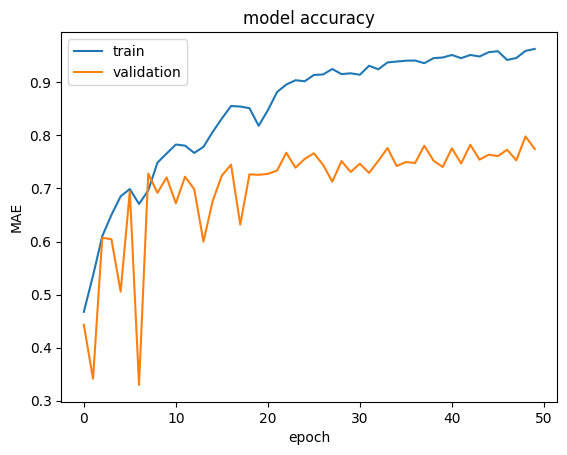

In [19]:
utils.plot_accuracy(histEfficientNet, "accuracy")

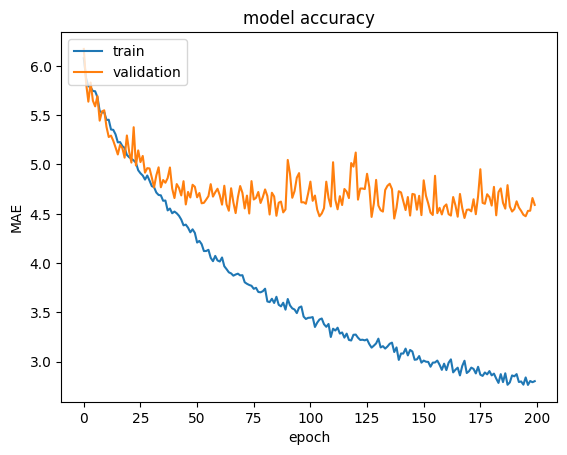

In [14]:
utils.plot_accuracy(histModel, "mean_absolute_error")

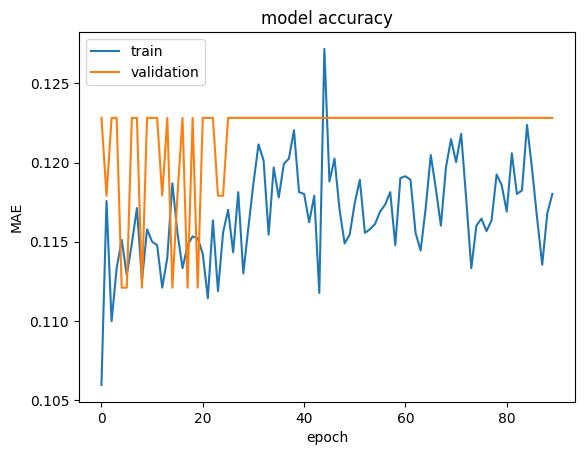

In [55]:
utils.plot_accuracy(histKrizhevsky, "accuracy")